Import Libraries


In [2]:
import math
import time
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
import random

import torch
from skimage.io import imread
from torch.utils import data
import torchvision.datasets as datasets
import nibabel as nib
from torch.utils.data import TensorDataset, DataLoader
import torchio as tio
from zipfile import ZipFile
import gzip
import sys
import shutil
import tarfile
import splitfolders

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler() #

In case you want to use gpu

In [2]:
use_gpu = torch.cuda.is_available()
use_gpu

True

In [3]:
file_path = os.path.abspath('') # At first It shows where the code is !
print(file_path)

C:\Users\nasta\Denoising\code


In [4]:
#DATASET_PATH="C:/Users/nasta/Denoising"
DATASET_PATH=file_path #where the dataset would be
os.chdir(DATASET_PATH)

There is the dataset .tar file in the DATASET_PATH called "IXI-T1.tar"
<br>
Let's unzip it and extract the data to "dataset"  folder

In [ ]:
#--------------------------------------------------------------------------------------------------
if not os.path.isdir(DATASET_PATH+'/dataset'):
    os.mkdir(DATASET_PATH+'/dataset')
#--------------------------------------------------------------------------------------------------
tar = tarfile.open("IXI-T1.tar")
os.chdir(DATASET_PATH+'/dataset')
tar.extractall()
tar.close()

Now in "dataset" folder we have many .gz file that
<br>
Let's extract each all of them to "unzippeddataset" folder

In [ ]:
def gz_size(fname):
    f = gzip.open(fname, 'r')
    data = f.read()
    f.close()
    return len(data)

#--------------------------------------------------------------------------------------------------
def zip_shutil(source_filepath, dest_filepath):
    with gzip.open(source_filepath, 'rb') as s_file, \
        open(dest_filepath, 'wb') as d_file:
        shutil.copyfileobj(s_file, d_file)
        d_file.close()
        s_file.close()
        
#--------------------------------------------------------------------------------------------------
if not os.path.isdir(DATASET_PATH+'/unzippeddataset'):
    os.mkdir(DATASET_PATH+'/unzippeddataset')
    
data_image_t1_zip_list=os.listdir(DATASET_PATH+'/dataset')    
for zipfilename in data_image_t1_zip_list: 
    if gz_size(zipfilename) != 0:
        zip_shutil(DATASET_PATH+'/dataset/'+zipfilename,DATASET_PATH+'/unzippeddataset/'+zipfilename.split('.')[0]+'.nii')  
#---------------------------------------------------------------------------------------------------------------

Let's apply a tio transform on the data; here randommotion 
<br> 
the clean images are saved in "clean" folder in "input" folder and
<br> 
the noisy images are saved in "noisy" folder in "input" folder 
<br>
<br>
two important notes:
<br> 
Images are 150 slices of 256 by 256 images ( shape = 256,256,150)
<br>
Yet, here for the sake of the memory 64 slices are selected
<br>
Since the clean and noisy images will be the input of the 3d convolutional neural network,
<br>
the final shape of them is 1,256,256,64 to satisfy num_chan,IMG_width,IMG_height,IMG_depth

In [ ]:
#---make noisy images----------------------------------------------------------------------
transform = tio.RandomMotion(
degrees=(1,3),
translation=(0.1,0.3),
image_interpolation='linear'
)
os.mkdir(DATASET_PATH+'/input/')
data_image_t1_list=os.listdir(DATASET_PATH+'/unzippeddataset')

if not os.path.isdir(DATASET_PATH+'/input/'+'noisy'):
    os.mkdir(DATASET_PATH+'/input/noisy/')
if not os.path.isdir(DATASET_PATH+'/input/'+'clean'):
    os.mkdir(DATASET_PATH+'/input/clean/')
    
for filename in data_image_t1_list: 
    data_image_t1=nib.load(DATASET_PATH+'/unzippeddataset/'+filename).get_fdata() 
    data_image_t1=data_image_t1[:,:,42:106]
    data_image_t1_extended=data_image_t1[np.newaxis,:,:,:]  #1,256,256,64
    data_tensor_t1 = torch.Tensor(data_image_t1_extended)
    
    transformed_data_tensor_t1=transform(data_tensor_t1)
    transformed_data_image_t1=transformed_data_tensor_t1.numpy()
    os.chdir(DATASET_PATH+'/input/clean/')
    np.save(filename.split('.')[0],data_image_t1_extended)
    os.chdir(DATASET_PATH+'/input/noisy/')
    np.save(filename.split('.')[0],transformed_data_image_t1)   


Let's split all the noisy and clean images to train and validation folder
<br>
with the ratio of 0.75 for train and 0.25 forvalidation

In [ ]:
input_folder = DATASET_PATH+'/input'
os.makedirs(DATASET_PATH+'/splittedinput')
output_folder = DATASET_PATH+'/splittedinput'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Let's take a look at one random image before and after the transform

In [ ]:
data_image_t1_list=os.listdir(DATASET_PATH+'/splittedinput/train/clean')
n_file=random.randint(0,len(data_image_t1_list))
filename=data_image_t1_list[n_file]
print(filename)

os.chdir(DATASET_PATH+'/splittedinput/train/clean/')
clean=np.load(filename.split('.')[0]+'.npy')
os.chdir(DATASET_PATH+'/splittedinput/train/noisy/')
noisy=np.load(filename.split('.')[0]+'.npy') 
print(clean.shape)
print(noisy.shape)
print('max clean',clean.max())
print('min clean',clean.min())
print('max noisy',noisy.max())
print('min noisy',noisy.min())
#----------------------------------------------------------------------------------------
n_slice=random.randint(0,noisy.shape[3]-1)
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(clean[0,:,:,n_slice-1],cmap='gray')
plt.title('clean image gray scale')
plt.subplot(222)
plt.imshow(clean[0,:,:,n_slice-1])
plt.title('clean image')
plt.subplot(223)
plt.imshow(noisy[0,:,:,n_slice-1],cmap='gray')
plt.title('noisy image with random motion gray scale')
plt.subplot(224)
plt.imshow(noisy[0,:,:,n_slice-1])
plt.title('noisy image with random motion')
plt.show()

Now it's time to create a dataset and dataloader
<br>
Because of memory limitation, dataset covers 90 training noisy-clean images and 30 noisy-clean validation images

In [5]:
train_clean = [] # a list of numpy arrays
train_noisy = [] # another list of numpy arrays

#-----------------dataset-----------------------------------------------
train_clean_data_image_t1_list=os.listdir(DATASET_PATH+'/splittedinput/train/clean/')
train_noisy_data_image_t1_list=os.listdir(DATASET_PATH+'/splittedinput/train/noisy/')

for filename in train_clean_data_image_t1_list[0:90]:  #90 for training 30 for validation
    os.chdir(DATASET_PATH+'/splittedinput/train/clean/')
    clean=np.load(filename)  #(1, 256, 256, 64)
    clean=scaler.fit_transform(clean.reshape(-1, clean.shape[-1])).reshape(clean.shape) #(1, 256, 256, 64)
    train_clean.append(clean)
    
for filename in train_noisy_data_image_t1_list[0:90]:
    os.chdir(DATASET_PATH+'/splittedinput/train/noisy/')
    noisy=np.load(filename)  #(1, 256, 256, 64)
    noisy=scaler.fit_transform(noisy.reshape(-1, noisy.shape[-1])).reshape(noisy.shape) #(1, 256, 256, 64)
    train_noisy.append(noisy)
    
tensor_clean = torch.Tensor(np.array(train_clean)) # transform to torch tensor
tensor_noisy = torch.Tensor(np.array(train_noisy))
train_dataset = TensorDataset(tensor_clean,tensor_noisy) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=2,shuffle=True) 

In [6]:
val_clean = [] # a list of numpy arrays
val_noisy = [] # another list of numpy arrays

#-----------------dataset-----------------------------------------------
val_clean_data_image_t1_list=os.listdir(DATASET_PATH+'/splittedinput/val/clean/')
val_noisy_data_image_t1_list=os.listdir(DATASET_PATH+'/splittedinput/val/noisy/')

for filename in val_clean_data_image_t1_list[90:120]:  #90 for training 30 for validation
    os.chdir(DATASET_PATH+'/splittedinput/val/clean/')
    clean=np.load(filename)  #(1, 256, 256, 64)
    clean=scaler.fit_transform(clean.reshape(-1, clean.shape[-1])).reshape(clean.shape) #(1, 256, 256, 64)
    val_clean.append(clean)
    
for filename in val_noisy_data_image_t1_list[90:120]:
    os.chdir(DATASET_PATH+'/splittedinput/val/noisy/')
    noisy=np.load(filename)  #(1, 256, 256, 64)
    noisy=scaler.fit_transform(noisy.reshape(-1, noisy.shape[-1])).reshape(noisy.shape) #(1, 256, 256, 64)
    val_noisy.append(noisy)
    
tensor_clean = torch.Tensor(np.array(val_clean)) # transform to torch tensor
tensor_noisy = torch.Tensor(np.array(val_noisy))
val_dataset = TensorDataset(tensor_clean,tensor_noisy) # create your datset
val_dataloader = DataLoader(val_dataset,batch_size=2,shuffle=True) 

It's time for Implementing the model

In [7]:
class conv_block(nn.Module):
    def __init__(self,in_c,out_c):
        
        super().__init__()

        self.conv1=nn.Conv3d(in_c,out_c,(3, 3, 3),padding=(1,1,1))  
        self.bn1=nn.BatchNorm3d(out_c)

        self.conv2=nn.Conv3d(out_c,out_c,(3, 3, 3),padding=(1,1,1))
        self.bn2=nn.BatchNorm3d(out_c)

        self.relu=nn.ReLU()


    def forward(self,inputs):
        x=self.conv1(inputs)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        print('converting {} to {}'.format(x.size(),x.size()))

        return x
#-------------------------------------------------------------------------------
class encoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()

        self.conv=conv_block(in_c,out_c)
        self.pool=nn.MaxPool3d((2,2,2))

    def forward(self,inputs):
        x=self.conv(inputs)
        p=self.pool(x)
        return x, p

#-------------------------------------------------------------------------------
class decoder_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        self.up=nn.ConvTranspose3d(in_c,out_c,(2,2,2),stride=(2, 2, 2), padding=(0, 0, 0)) 
        self.conv=conv_block(out_c + out_c,out_c)
        
              
    def forward(self,inputs,skip):
        print('first input  is',inputs.size())
        x=self.up(inputs) 
        print('now input is',x.size())
        print('skip is',skip.size())
        x=torch.cat([x,skip],axis=1)
        x=self.conv(x)
        print('converting {} to {}'.format(inputs.size(),x.size()))
        return x


#-------------------------------------------------------------------------------
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """Encoder"""
        self.e1=encoder_block(1,16)  #1x3x128x128x128 #(1,256, 256, 64)  to 1x16x64x64x64 #(16,128,128,32)    
        self.e2=encoder_block(16,32) #1x16x64x64x64 #(16,128,128,32)   to 1x32x32x32x32 #(32,64,64,16) 
        self.e3=encoder_block(32,64) #1x32x32x32x32 #(32,64,64,16) to 1x64x16x16x16 #(64,32,32,8)
        self.e4=encoder_block(64,128)  #1x64x16x16x16 #(64,32,32,8) to 1x128x8x8x8 #(128,16,16,4)

        """Bottleneck"""
        self.b=conv_block(128,256) #1x128x8x8x8 #(128,16,16,4) to 1x256x8x8x8 #(256,16,16,4)

        """decoder"""
        self.d1=decoder_block(256,128) #1x256x8x8x8 to 1x128x16x16x16  number of channels= 256 to 128 then +128 
                                       #(256,16,16,4) to #(128,32,32,8) 
        self.d2=decoder_block(128,64)  #1x128x16x16x16 to 1x64x32x32x32  number of channels= 128 to 64 then +64
                                       #(128,32,32,8) to #(64,64,64,16) 
        self.d3=decoder_block(64,32)  #1x64x32x32x32 to 1x32x64x64x64  number of channels= 64 to 32 then 32 
                                       #(64,64,64,16)  to #(32,128,128,32) 
        self.d4=decoder_block(32,16)  #1x32x64x64x64 to 1x16x128x128x128  number of channels= 32 to 16 then +16 
                                      #(32,128,128,32)  to #(16,256,256,64)

        """ Classifier """
        self.outputs=nn.Conv3d(16,1,(1,1,1),padding=(0, 0, 0)) #1x16x128x128x128 to #1x4x128x128x128
                                                               #(16,256,256,64) to #(1,256,256,64)

    def forward(self,inputs):
        s1,p1=self.e1(inputs) #s1 1x16x128x128x128 p1 1x16x64x64x64
        s2,p2=self.e2(p1)     #s2 1x32x64x64x64    p2 1x32x32x32x32
        s3,p3=self.e3(p2)     #s3 1x64x32x32x32    p3 1x64x16x16x16
        s4,p4=self.e4(p3)     #s4 1x128x16x16x16   p4 1x128x8x8x8

        b=self.b(p4)          #1x128x8x8x8  to #1x256x8x8x8

        print(b.size())
        print(s4.size())
        
        d1=self.d1(b,s4)     #d1 1x128x16x16x16
        d2=self.d2(d1,s3)    #d2 1x64x32x32x32
        d3=self.d3(d2,s2)    #d3 1x32x64x64x64
        d4=self.d4(d3,s1)    #d4 1x16x128x128x128

        outputs= self.outputs(d4) 

        return outputs

In [ ]:
class Autoencoder3D(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 256, 256 ,64       1 28 28
        self.encoder = nn.Sequential(
            nn.Conv3d(1,16,(3, 3, 3),stride=(2, 2,2 ),padding=(1,1,1 )), #N, 16,128,128,32    
            #nn.Conv2d(1, 16, 3, stride=2, padding=1), # ->  16 14 14
            nn.ReLU(),
            nn.Conv3d(16,32,(3, 3, 3),stride=(2, 2,2 ),padding=(1, 1,1)),#N, 32,64,64,16  
            #nn.Conv2d(16, 32, 3, stride=2, padding=1), # ->  32 7 7
            nn.ReLU(),
            nn.Conv3d(32,64,(3,3,3),stride=(2,2,2),padding=(1, 1,1 )) # N, 64, 1, 1,1
            #nn.Conv2d(32, 64, 128) # -> N, 64, 1, 1
        )
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(64, 32, 128), # -> N, 32, 7, 7   
            nn.ConvTranspose3d(64,32,3,stride=(2, 2,2 ),padding=(1, 1,1 ),output_padding=(1, 1, 1)), #32,64,64,16
            nn.ReLU(),
            nn.ConvTranspose3d(32,16,3,stride=(2, 2, 2),padding=(1, 1, 1),output_padding=(1, 1, 1)), #16,128,128,32 #padding=(1, 1, 1),
            #nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose3d(16,1,3,stride=(2, 2, 2), padding=(1, 1, 1),output_padding=(1, 1, 1)), #1,256,256,64 #padding=(1, 1, 1),
            #nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            #nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class Autoencoder2D(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 64, 256, 256
        self.encoder = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # -> N, 32, 128, 128
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # -> N, 16, 64, 64
            #nn.ReLU(),
            #nn.Conv2d(16, 8, stride=2, padding=1) # -> N, 8, 32, 32
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3,stride=2, padding=1, output_padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            #nn.ReLU(),
            #nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            #nn.Sigmoid()
            #nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
model = build_unet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = model.to(device)

#model = Autoencoder3D()
#model = Autoencoder2D()
criterion = nn.MSELoss() #noooo
#optimizer = torch.optim.Adam(model.parameters(),
                             #lr=1e-4, 
                             #weight_decay=1e-5,
                             #eps=1e-08)
#criterion = nn.CrossEntropyLoss()
#criterion =nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
lr = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9,weight_decay=1e-5)

In [13]:
num_epochs =1
outputs = []
losses=[]
batch_number=0
epoch_number=8
batch_number=0
Mx=[]
Mn=[]
for epoch in range(num_epochs):
    epoch_number+=1
    for i, (clean, noisy) in enumerate(train_dataloader):
        batch_number+=1
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        #print(img.size())
        #noisy=noisy[0,0,:,:,:]
        #noisy= np.transpose(noisy, (2, 0, 1)) #64, 256, 256
        #clean=clean[0,0,:,:,:]
        #clean= np.transpose(clean, (2, 0, 1)) #64, 256, 256
        
        #clean=clean
        #noisy=noisy
        
        recon = model(noisy)
                      
        #recon=recon
        #recon = recon[0,:,:,:]
        #recon = recon.squeeze(1)
        print('recon',recon.size())
        
        #clean = clean[0,:,:,:]
        #clean = clean.squeeze()
        print('clean',clean.size())
        
        loss = criterion(clean,recon)
        losses.append(loss.item())
        Mx.append(recon.max().detach().numpy())
        Mn.append(recon.min().detach().numpy())
        print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('epoch number ',epoch_number,' batch_number ',batch_number)
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, noisy,clean, recon))

converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 256, 16, 16, 4])
torch.Size([2, 256, 16, 16, 4])
torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 256, 16, 16, 4])
now input is torch.Size([2, 128, 32, 32, 8])
skip is torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 128, 32, 32, 8])
now input is torch.Size([2, 64, 64, 64, 16])
skip is torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32,

converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 32, 128, 128, 32])
first input  is torch.Size([2, 32, 128, 128, 32])
now input is torch.Size([2, 16, 256, 256, 64])
skip is torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 16, 256, 256, 64])
recon torch.Size([2, 1, 256, 256, 64])
clean torch.Size([2, 1, 256, 256, 64])
0.17853127419948578
epoch number  9  batch_number  5
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 256, 16, 16, 4])
torch.

converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 128, 32, 32, 8])
now input is torch.Size([2, 64, 64, 64, 16])
skip is torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 64, 64, 64, 16])
first input  is torch.Size([2, 64, 64, 64, 16])
now input is torch.Size([2, 32, 128, 128, 32])
skip is torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 32, 128, 128, 32])
first input  is torch.Size([2, 32, 128, 128, 32])
now input is torch.Size([2, 16, 256, 256, 64])
skip is torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 

epoch number  9  batch_number  14
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 256, 16, 16, 4])
torch.Size([2, 256, 16, 16, 4])
torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 256, 16, 16, 4])
now input is torch.Size([2, 128, 32, 32, 8])
skip is torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 128, 32, 32, 8])
now input is torch.Size([2, 64, 64, 64, 16])
skip is torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
conv

converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 32, 128, 128, 32])
first input  is torch.Size([2, 32, 128, 128, 32])
now input is torch.Size([2, 16, 256, 256, 64])
skip is torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 16, 256, 256, 64])
recon torch.Size([2, 1, 256, 256, 64])
clean torch.Size([2, 1, 256, 256, 64])
0.12069981545209885
epoch number  9  batch_number  19
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 256, 16, 16, 4])
torch

converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 128, 32, 32, 8])
now input is torch.Size([2, 64, 64, 64, 16])
skip is torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 64, 64, 64, 16])
first input  is torch.Size([2, 64, 64, 64, 16])
now input is torch.Size([2, 32, 128, 128, 32])
skip is torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 32, 128, 128, 32])
first input  is torch.Size([2, 32, 128, 128, 32])
now input is torch.Size([2, 16, 256, 256, 64])
skip is torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 

epoch number  9  batch_number  28
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 256, 16, 16, 4])
torch.Size([2, 256, 16, 16, 4])
torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 256, 16, 16, 4])
now input is torch.Size([2, 128, 32, 32, 8])
skip is torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 128, 32, 32, 8])
now input is torch.Size([2, 64, 64, 64, 16])
skip is torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
conv

converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 32, 128, 128, 32])
first input  is torch.Size([2, 32, 128, 128, 32])
now input is torch.Size([2, 16, 256, 256, 64])
skip is torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 16, 256, 256, 64])
recon torch.Size([2, 1, 256, 256, 64])
clean torch.Size([2, 1, 256, 256, 64])
0.09544365853071213
epoch number  9  batch_number  33
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 256, 16, 16, 4])
torch

converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 64, 64, 64, 16])
first input  is torch.Size([2, 64, 64, 64, 16])
now input is torch.Size([2, 32, 128, 128, 32])
skip is torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 32, 128, 128, 32])
first input  is torch.Size([2, 32, 128, 128, 32])
now input is torch.Size([2, 16, 256, 256, 64])
skip is torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 16, 256, 256, 64])
recon torch.Size([2, 1, 256, 256, 64])
clean torch.Size([2, 1, 256, 256, 64])
0.08949597924947739
epoch number  9  batch_number  38
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32

converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 128, 32, 32, 8])
converting torch.Size([2, 256, 16, 16, 4]) to torch.Size([2, 128, 32, 32, 8])
first input  is torch.Size([2, 128, 32, 32, 8])
now input is torch.Size([2, 64, 64, 64, 16])
skip is torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 64, 64, 64, 16])
converting torch.Size([2, 128, 32, 32, 8]) to torch.Size([2, 64, 64, 64, 16])
first input  is torch.Size([2, 64, 64, 64, 16])
now input is torch.Size([2, 32, 128, 128, 32])
skip is torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 32, 128, 128, 32]) to torch.Size([2, 32, 128, 128, 32])
converting torch.Size([2, 64, 64, 64, 16]) to torch.Size([2, 32, 128, 128, 32])
first input  is torch.Size([2, 32, 128, 128, 32])
now input is torch.Size([2, 16, 256, 256, 64])
skip is torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 16, 256, 256, 64]) to torch.Size([2, 16, 256, 256, 64])
converting torch.Size([2, 32, 128, 

<br>First Results</br>

0.01036254595965147
1.4428421
-0.7787536


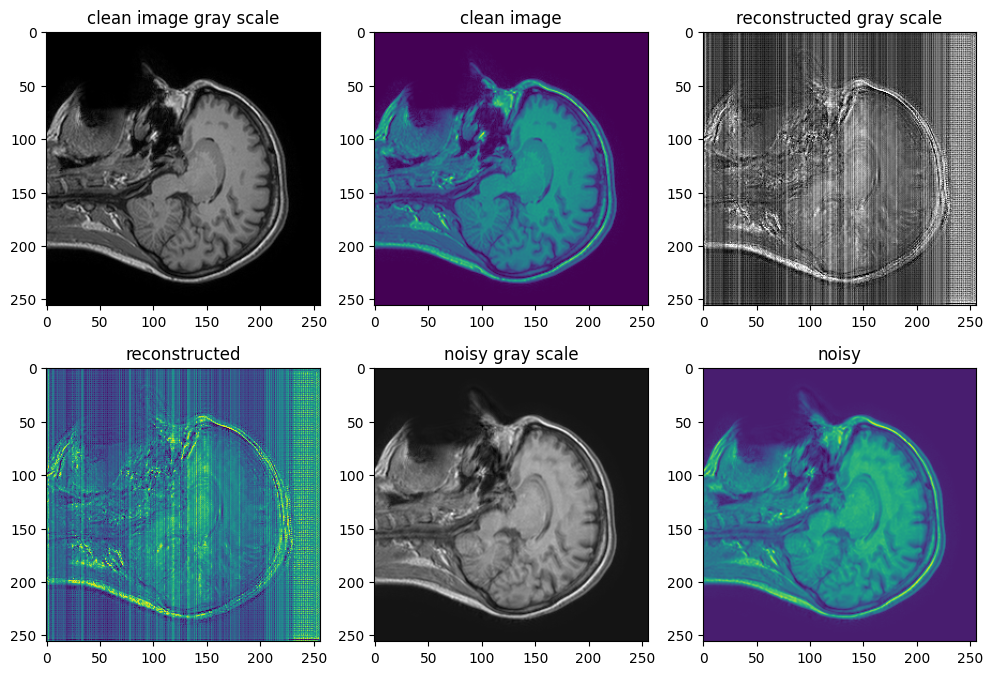

In [29]:
#1 8 epochs
print(losses[-1])
print(Mx[-1])
print(Mn[-1])
#n_slice=random.randint(0,64)
n_slice=25
plt.figure(figsize=(12,8))
plt.subplot(231)  
plt.imshow(outputs[0][2][0,0,:,:,n_slice-1].detach().numpy(),cmap='gray')
plt.title('clean image gray scale')
plt.subplot(232)
plt.imshow(outputs[0][2][0,0,:,:,n_slice-1].detach().numpy())
plt.title('clean image')
recon=outputs[0][3][0,0,:,:,n_slice-1].detach().numpy()
recon=scaler.fit_transform(recon.reshape(-1, recon.shape[-1])).reshape(recon.shape)
plt.subplot(233)
plt.imshow(recon,cmap='gray')
plt.title('reconstructed gray scale')
plt.subplot(234)
plt.imshow(recon)
plt.title('reconstructed')
plt.subplot(235)
plt.imshow(outputs[0][1][0,0,:,:,n_slice-1].detach().numpy(),cmap='gray')
plt.title('noisy gray scale')
plt.subplot(236)
plt.imshow(outputs[0][1][0,0,:,:,n_slice-1].detach().numpy())
plt.title('noisy')
plt.show()

<br>MSELoss Loss</br>

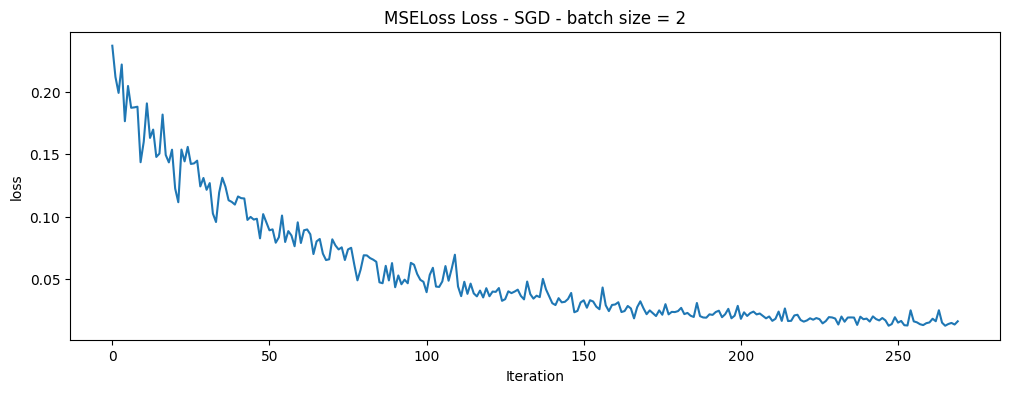

In [24]:
plt.figure(figsize=(12,4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('MSELoss Loss - SGD - batch size = 2')
plt.show()

<br>Maximum pixel value should reach one<br>

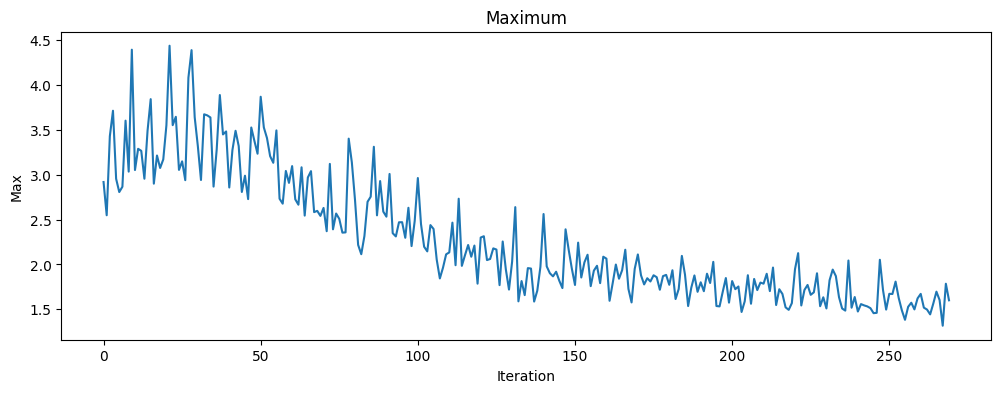

1.6007992


In [25]:
plt.figure(figsize=(12,4))
plt.plot(Mx)
plt.xlabel('Iteration')
plt.ylabel('Max')
plt.title('Maximum')
plt.show()
print(Mx[-1])

<br>Minimum pixel value should reach zero</br>

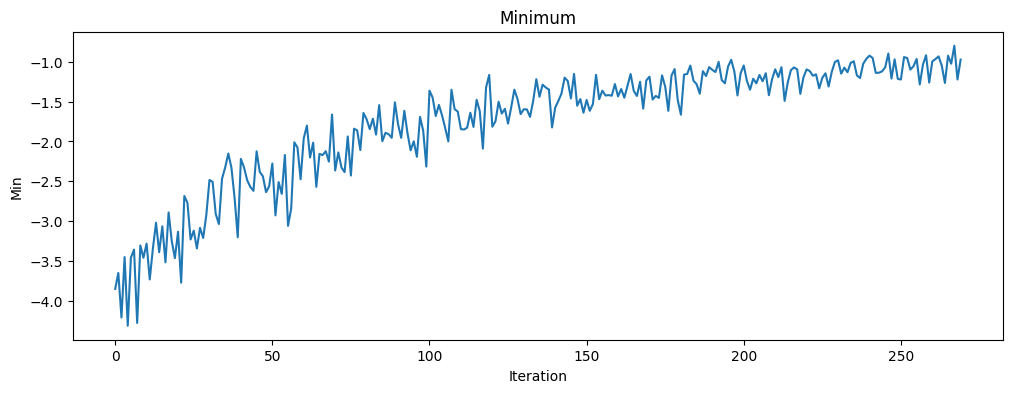

-0.9745842


In [26]:
plt.figure(figsize=(12,4))
plt.plot(Mn)
plt.xlabel('Iteration')
plt.ylabel('Min')
plt.title('Minimum')
plt.show()
print(Mn[-1])